In [1]:
# import packages

import cv2
import numpy as np
import pandas as pd
import math
import os
import matplotlib
from matplotlib import pyplot as plt

dir_path = os.getcwd()

# lettura foto

nomefile = raw_input('Inserisci il nome del file:')
percorso = dir_path + '\\' + nomefile

Inserisci il nome del file:photo-test.jpg


## Lettura immagine

In [2]:
img = cv2.imread(percorso)
img_small = cv2.resize(img, (0,0), fx=0.25, fy=0.25)
img_big = cv2.resize(img, (0,0), fx=3, fy=3)
gray = cv2.cvtColor(img_small, cv2.COLOR_BGR2GRAY)

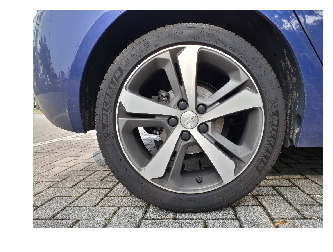

In [3]:
plt.axis("off")
plt.imshow(cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB))

### Identifico circonferenze

In [4]:
circles = cv2.HoughCircles(gray,  method=cv2.HOUGH_GRADIENT, dp=1, minDist=3,
                           circles=None, minRadius=200, maxRadius=500, param1=300, param2=200)
circles = np.int0(np.array(circles))
circles_df = pd.DataFrame(circles[0], columns=['X','Y','R'])

In [5]:
circles_df.head()

,X,Y,R
0,560,384,339
1,555,388,261
2,558,389,256
3,568,389,349
4,565,385,345


In [6]:
X = int(circles_df.X.mean()) # centro medio, coordinata X
Y = int(circles_df.Y.mean()) # centro medio, coordinata Y
R = int(circles_df.R.mean()) # raggio medio
Rmax = int(circles_df.R.max()) # raggio massimo

### Disegno i cerchi rilevati sull'immagine

In [7]:
imgcopy = img_small.copy()
for i in range(len(circles_df)):
    x=circles_df.iloc[i,0]
    y=circles_df.iloc[i,1]
    r=circles_df.iloc[i,2]
    cv2.circle(imgcopy, (x,y), r, (0,255,0), 1, 16)

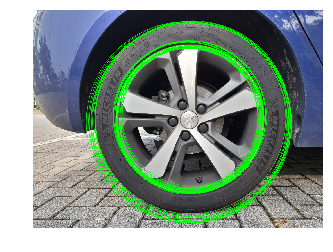

In [8]:
plt.axis("off")
plt.imshow(cv2.cvtColor(imgcopy, cv2.COLOR_BGR2RGB))

### Disegno i cerchi teorici sull'immagine

In [9]:
for r in range(100, Rmax, 30):
    cv2.circle(imgcopy, (X,Y), r, (0, 0, 255), 3, cv2.LINE_AA)

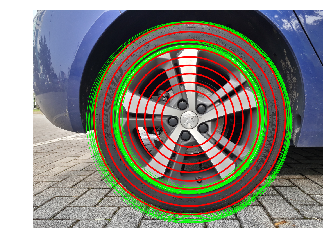

In [10]:
plt.axis("off")
plt.imshow(cv2.cvtColor(imgcopy, cv2.COLOR_BGR2RGB))

### Ritaglio l'immagine con centro nel centro del cerchio    

In [11]:
X1 = int(X*3/0.25)
Y1 = int(Y*3/0.25)
R1 = int(Rmax*3/0.25)
img_crop = img_big[Y1-R1:Y1+R1, X1-R1:X1+R1].copy()

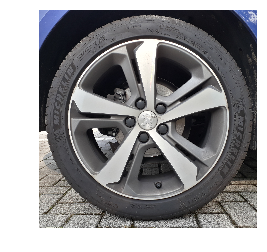

In [12]:
plt.axis("off")
plt.imshow(cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB))

### Trasformazione da polare per raddrizzare la striscia di gomma

In [13]:
img_polar = cv2.logPolar(img_crop, (R1,R1), 85*3/0.25, cv2.WARP_FILL_OUTLIERS )
img_rotated = cv2.rotate(img_polar, cv2.ROTATE_90_COUNTERCLOCKWISE)

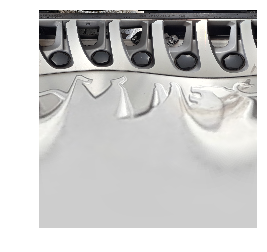

In [14]:
plt.axis("off")
plt.imshow(cv2.cvtColor(img_rotated, cv2.COLOR_BGR2RGB))

### Taglio l'immagine e identifico linee, passo 1

In [15]:
img_rotated = img_rotated[0:int(img_rotated.shape[0]*0.1), :]

img_rotated_small = cv2.resize(img_rotated, (0,0), fx=0.4, fy=0.4)
gray2 = cv2.cvtColor(img_rotated_small, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray2, 50, 300)
lines = cv2.HoughLinesP(edges, rho = 1,theta = math.pi/2, threshold = 10, minLineLength = int(edges.shape[1]*0.5), maxLineGap = 70)
lines = pd.DataFrame([i[0] for i in lines], columns=['X1','Y1','X2','Y2'])

In [16]:
img_rotated_croped = img_rotated[int(min(lines.Y1)/0.4):, :]

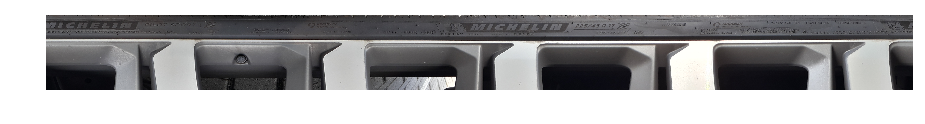

In [17]:
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.figsize'] = 30,1
plt.axis("off")
plt.imshow(cv2.cvtColor(img_rotated_croped, cv2.COLOR_BGR2RGB))

### Taglio l'immagine e identifico linee, passo 2

In [18]:
img_rotated_small = cv2.resize(img_rotated_croped, (0,0), fx=0.4, fy=0.4)
gray2 = cv2.cvtColor(img_rotated_small, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray2, 100, 200)
lines = cv2.HoughLinesP(edges, rho = 1,theta = math.pi/2, threshold = 100, minLineLength = int(edges.shape[1]*0.8), maxLineGap = 400)
lines = pd.DataFrame([i[0] for i in lines], columns=['X1','Y1','X2','Y2'])

In [19]:
# in questo caso scelgo la linea piu vicina alla meta
lines['delta']=(lines.Y1-int(img_rotated_small.shape[0]/2))**2
minimo = int(lines.Y1[lines.delta==min(lines.delta)])

img_rotated_croped = img_rotated_croped[:int(minimo/0.4), :]
resized_image = cv2.resize(img_rotated_croped, (8400, 322)) 

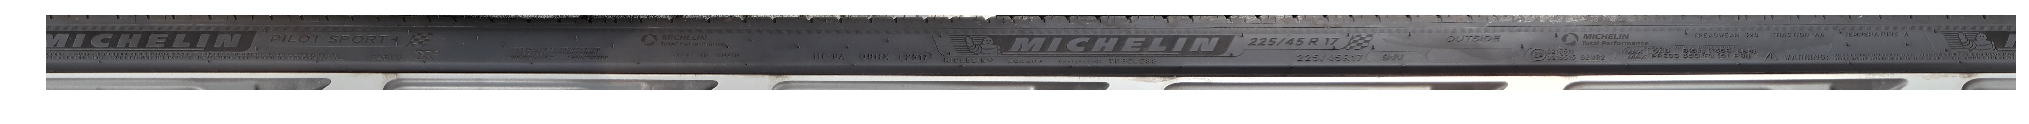

In [20]:
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.figsize'] = 30,1
plt.axis("off")
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))

### Taglio in 3 l'immagine verticalmente e le unisco per migliore visualizzazione

In [21]:
img1 = resized_image[:,0:2800]
img2 = resized_image[:,2800:5600]
img3 = resized_image[:,5600:8500]
final_img = np.concatenate((img1,img2,img3),axis=0)

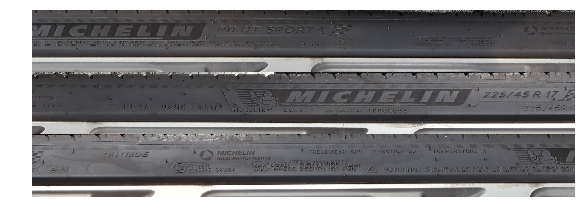

In [22]:
matplotlib.rcParams['figure.dpi'] = 70
matplotlib.rcParams['figure.figsize'] = 10,4
plt.axis("off")
plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))